<a href="https://colab.research.google.com/github/daliaydom/Tarea2_AprendizajeProfundo/blob/main/T2Ejercicio2_Rostros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gibranfp/CursoAprendizajeProfundo/blob/2023-1/notebooks/2e_transfer_class.ipynb)
[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://www.kaggle.com/notebooks/welcome?src=https://github.com/gibranfp/CurasoAprendizajeProfundo/blob/2023-1/notebooks/2e_transfer_class.ipynb)
[![Gradient](https://assets.paperspace.io/img/gradient-badge.svg)](https://console.paperspace.com/github/gibranfp/CursoAprendizajeProfundo/blob/2023-1/notebooks/2e_transfer_class.ipynb)

# Ejercicio 2: Predicción de edades
Dalia Yvette Domínguez Jiménez

El conjunto de datos UTKFace es un conjunto de datos de rostros a gran escala con un amplio rango de edad (entre 0 y 116 años). El conjunto de datos consta de más de 20.000 imágenes faciales con anotaciones de edad, sexo y origen étnico. Las imágenes cubren una gran variación en cuanto a pose, expresión facial, iluminación, oclusión, resolución, etc. Este conjunto de datos puede utilizarse en diversas tareas, como la detección de rostros, la estimación de la edad, la progresión/regresión de la edad, la localización de puntos de referencia, etc. A continuación se muestran algunas imágenes de muestra

<img src="https://susanqq.github.io/UTKFace/icon/samples.png" width="950" height="750" />


## 1. Preparación

In [1]:
# Colab
%pip install -q torchinfo

### 1.1 Bibliotecas

In [2]:
# marcas de tiempo
import datetime
# explorar el sistema de archivos
import glob
# sistema de archivos
import os
# funciones aleatorias
import random
# marcas de tiempo
import time
# tomar n elementos de una secuencia
from itertools import islice as take
# sistema de archivos
from os.path import join

# gráficas
import matplotlib.patches as patches
import matplotlib.pyplot as plt
# arreglos multidimensionales
import numpy as np
# csv
import pandas as pd
# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets.utils as tvu
import torchvision.models as tvm
import torchvision.transforms as T
# leer archivo matlab
from scipy.io import loadmat
# cargador de datos
from torch.utils.data import DataLoader
# trazas de Tensorboard
from torch.utils.tensorboard import SummaryWriter
# inspección de arquitectura
from torchinfo import summary
# barra de progreso
from tqdm.auto import trange
# imágenes
from PIL import Image
!pip install timm
import timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 548 kB 37.6 MB/s 
     |████████████████████████████████| 163 kB 61.4 MB/s 


### 1.2. Auxiliares

In [3]:
# directorio de datos
URL = 'https://cloud.xibalba.com.mx/s/QpJdJ5aLEDG9Ryb/download'
base_dir = '../data/faces'
filename = 'UTKFace.tar.gz'
data_dir = '../data/faces/UTKFace'
filepath = os.path.join(base_dir, filename)

# tamaño del lote
BATCH_SIZE = 32
# filas y columnas de la rejilla de imágenes
ROWS, COLS = 4, 8
# tamaño de la imagen
IMG_SIZE = 150

# media y varianza de de ImageNet
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]


def display_grid(xs, titles, rows, cols, figsize=(12, 6)):
    """Despliega un ejempos en una cuadrícula."""
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    i = 0
    for r in range(rows):
        for c in range(cols):
            ax[r, c].imshow(xs[i], cmap='gray')
            ax[r, c].set_title(titles[i])
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
            i += 1
    fig.tight_layout()
    plt.show()


def display_batch(x, titles, rows, cols, figsize=(12, 6)):
    """Despliega un lote en una cuadrícula."""
    # denormalizamos
    for c, (mean, std) in enumerate(zip(IMAGENET_MEAN, IMAGENET_STD)):
        x[:, c] = x[:, c] * std + mean 
    x *= 255
    # rotamos canales
    x = x.permute(0, 2, 3, 1)
    # convertimos a entero
    x = (x.numpy()).astype(np.uint8)
    # desplegamos lote
    display_grid(x, titles, rows, cols, figsize)


def timestamp(fmt='%y%m%dT%H%M%S'):
    """Regresa la marca de tiempo."""
    return datetime.datetime.fromtimestamp(time.time()).strftime(fmt)


def set_seed(seed=0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


# reproducibilidad
set_seed()

## 2. Datos

### 2.1 Conjunto de datos

Especificaciones:
- consta de más de 20k imágenes de rostros en la naturaleza (sólo un rostro en una imagen)
- proporciona los rostros correspondientes alineados y recortados
- proporciona los puntos de referencia correspondientes (68 puntos)
- las imágenes están etiquetadas por edad, sexo y origen étnico
- Las etiquetas de cada imagen facial están incrustadas en el nombre del archivo, formadas como [edad]_[género]_[raza]_[fecha y hora].jpg

Etiquetas:
- [edad] es un número entero de 0 a 116, que indica la edad
- [género] es 0 (hombre) o 1 (mujer)
- [raza] es un número entero de 0 a 4, que denota la condición de blanco, negro, asiático, indio y otros (como hispano, latino, de Oriente Medio).
- [fecha y hora] tiene el formato yyyymmddHHMMSSFFF, que muestra la fecha y la hora en que se recogió una imagen en UTKFace


### 2.2 Descargar datos

In [4]:
! mkdir -p {base_dir}
! wget -nc {URL} -O {filepath}

--2022-11-14 07:42:01--  https://cloud.xibalba.com.mx/s/QpJdJ5aLEDG9Ryb/download
Resolving cloud.xibalba.com.mx (cloud.xibalba.com.mx)... 187.188.130.162
Connecting to cloud.xibalba.com.mx (cloud.xibalba.com.mx)|187.188.130.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106634631 (102M) [application/x-gzip]
Saving to: ‘../data/faces/UTKFace.tar.gz’

../data/faces/UTKFa 100%[===================>] 101.69M  7.24MB/s    in 42s     

2022-11-14 07:42:45 (2.42 MB/s) - ‘../data/faces/UTKFace.tar.gz’ saved [106634631/106634631]



In [5]:
! tar -zxf {filepath} -C {base_dir}

In [6]:
! ls {data_dir} | head -5

100_0_0_20170112213500903.jpg.chip.jpg
100_0_0_20170112215240346.jpg.chip.jpg
10_0_0_20161220222308131.jpg.chip.jpg
10_0_0_20170103200329407.jpg.chip.jpg
10_0_0_20170103200522151.jpg.chip.jpg


### 2.3 Tuberias de datos con PyTorch

<img src="https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/2023-1/figs/comida_datos.svg" width="950" height="750" />

In [7]:
class RecipesDS:

    def __init__(self, root, files, tsfm):
          
        # guardamos la tranformación para las imágenes
        self.tsfm = tsfm

        # lista con las rutas a las imágenes
        self.paths = [os.path.join(root,file) for file in files]
        # lista con las etiquetas de las imágenes
        self.labels = [file.split("_")[0] for file in files]
      

    def __getitem__(self, i):
        # obtenemos la ruta de la imagen
        path = self.paths[i]
        # cargamos la imagen
        x = Image.open(path)
        # aplicamos transformación
        x = self.tsfm(x)
        # leeamos la etiqueta
        y = np.array(self.labels[i], np.float32).reshape(1)
        # regresamos el ejemplo
        return x, y

    def __len__(self):
        # número de ejemplos en el conjunto
        return len(self.paths)

### 2.4 Exploración del conjunto de datos

In [8]:
files = os.listdir(data_dir)
tsfm = T.Compose([
    # recortamos al centro a 240x240
    T.CenterCrop(IMG_SIZE),
    # redimensionamos a 64x64
    T.Resize(IMG_SIZE),
    # convertimos a ndarray
    np.array
])
ds = RecipesDS(data_dir, files, tsfm)

x shape=torch.Size([32, 150, 150, 3]) dtype=torch.uint8
y shape=torch.Size([32, 1]) dtype=torch.float32


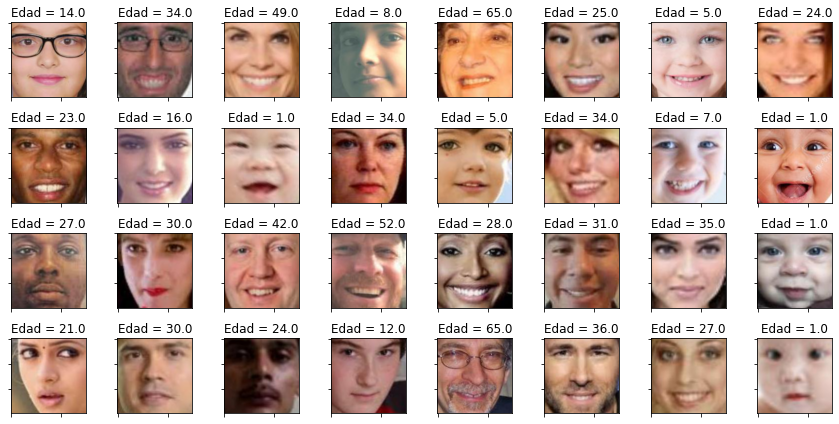

In [9]:
dl = DataLoader(
    # conjunto
    ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

# desplegamos un lote de imágenes
x, y = next(iter(dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
titles = [f'Edad = {l.item()}' for l in y]
display_grid(x, titles, ROWS, COLS)

### 2.5 Subconjuntos de entrenamiento y validación

In [11]:
random.shuffle(files)
files_train=files[int(0.2*len(files)):]
files_test=files[:int(0.2*len(files))]

### 2.6 Transformaciones

Torchvision tiene un conjunto de [transformaciones](https://pytorch.org/docs/1.6.0/torchvision/transforms.html) para ser ejecutadas de forma secuencial cuando se la pasamos a la clase `Compose`.

#### 2.6.1 Transformaciones de entrenamiento

In [12]:
# transformación de entrenamiento
trn_tsfm = T.Compose([
    # redimensionamos a Wx224 o 224xH
    T.Resize(IMG_SIZE),
    # cortamos al centro 224x224
    T.CenterCrop(IMG_SIZE),
    # aumentado de datos
    # espejeo horizontal aleatorio
    T.RandomHorizontalFlip(),
    # convertimos a torch.Tensor [3,H,W]
    # escalamos a [0,1]
    T.ToTensor(),
    # estandarizamos con media y varianza
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])
# conjunto
trn_ds = RecipesDS(data_dir,files_train,trn_tsfm)

#### 2.6.2 Transformaciones de validación

In [13]:
# transformación de validación
val_tsfm = T.Compose([
    # redimensionamos a Wx224 o 224xH
    T.Resize(IMG_SIZE),
    # cortamos al centro 224x224
    T.CenterCrop(IMG_SIZE),
    # convertimos a torch.Tensor [3,H,W]
    # escalamos a [0,1]
    T.ToTensor(),
    # estandarizamos con media y varianza
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])
# conjunto
val_ds = RecipesDS(data_dir,files_test,val_tsfm)

### 2.7 Cargadores de datos

Los [cargadores de datos](https://pytorch.org/docs/1.6.0/data.html) pueden precargar el siguiente lote de de entrenamiento forma paralela si especificamos `num_workers => 2`.

<img src="https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/2023-1/figs/data-loading1.png" />
<img src="https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/2023-1/figs/data-loading2.png" />
Fuente: tensorflow.org

#### 2.7.1 Carga de datos de entrenamiento

x shape=torch.Size([32, 3, 150, 150]) dtype=torch.float32
y shape=torch.Size([32, 1]) dtype=torch.float32


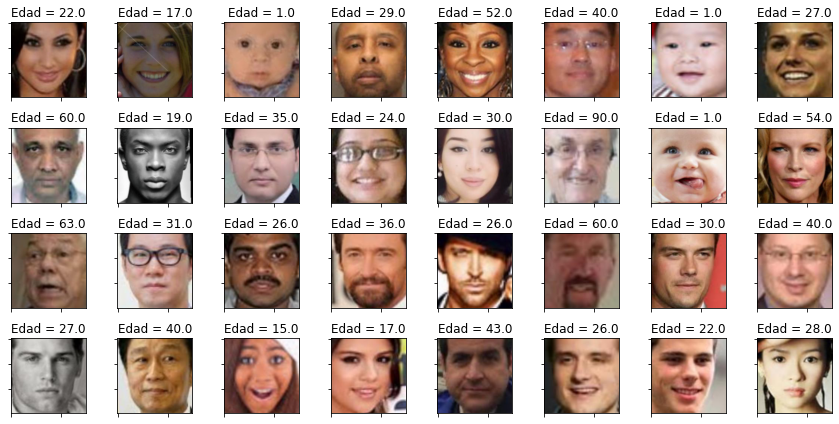

In [14]:
# creamos cargador
trn_dl = DataLoader(
    # conjunto
    trn_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True,
    # número de procesos paralelos
    num_workers=2
)
# desplegamos lote
batch = next(iter(trn_dl))
x, y = batch[0] , batch[1]
titles = [f'Edad = {l.item()}' for l in y]
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
display_batch(x, titles, ROWS, COLS)

#### 2.7.1 Carga de datos de validación

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


x shape=torch.Size([32, 3, 150, 150]) dtype=torch.float32
y shape=torch.Size([32, 1]) dtype=torch.float32


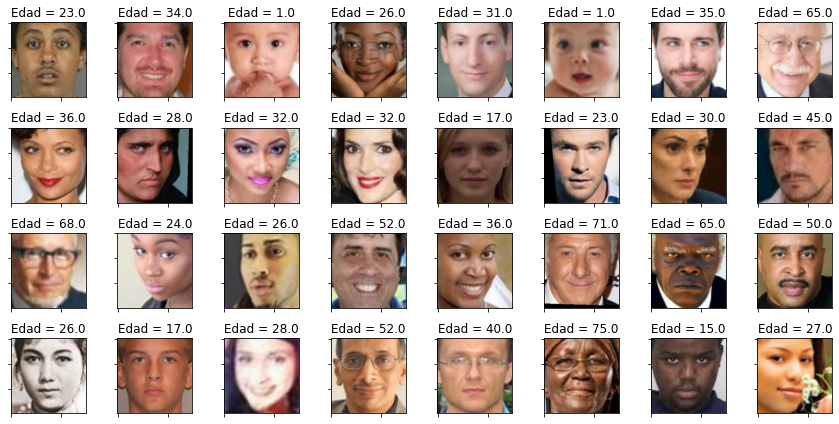

In [15]:
# creamos cargador
val_dl = DataLoader(
    # conjunto
    val_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True,
    # número de procesos paralelos
    num_workers=4
)
# desplegamos lote
batch = next(iter(val_dl))
x, y = batch[0] , batch[1]
titles = [f'Edad = {l.item()}' for l in y]
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
display_batch(x, titles, ROWS, COLS)

## 3. Modelo

Torchvision provee una familia de [modelos](https://pytorch.org/docs/1.6.0/torchvision/models.html#classification) preentrenados en ImageNet. Usaremos convnext_base

In [16]:
# instancia de modelo y carga de pesos
# model = tvm.shufflenet_v2_x0_5(pretrained=True)
# model = tvm.convnext_tiny(pretrained=True)
timm.list_models("convnext*")

['convnext_atto',
 'convnext_atto_ols',
 'convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_femto',
 'convnext_femto_ols',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_nano',
 'convnext_nano_ols',
 'convnext_pico',
 'convnext_pico_ols',
 'convnext_small',
 'convnext_small_384_in22ft1k',
 'convnext_small_in22ft1k',
 'convnext_small_in22k',
 'convnext_tiny',
 'convnext_tiny_384_in22ft1k',
 'convnext_tiny_hnf',
 'convnext_tiny_in22ft1k',
 'convnext_tiny_in22k',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_xlarge_in22k']

### 3.1 Carga de modelo: ConvNext

In [ ]:
model = timm.create_model("convnext_base", pretrained=True) # Will take a moment

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_base_1k_224_ema.pth" to /root/.cache/torch/hub/checkpoints/convnext_base_1k_224_ema.pth


In [ ]:
model

In [ ]:
model.head.fc 

In [ ]:
summary(model, (1, 3, IMG_SIZE, IMG_SIZE), 
        device='cpu', verbose=0)

### 3.2 Transferencia de conocimiento

#### 3.2.1 Congelamos los parámetros y cambiamos la última capa

In [ ]:
# congelamos los parámetros
for param in model.parameters():
    # no participa en la retropropagación
    param.requires_grad = False
# congelamos las estadísticas
model.eval()

# cambiamos la última capa de clasificación
model.head.fc = nn.Linear(in_features=1024, out_features=116, bias=True)

# inspección
summary(model, (1, 3, IMG_SIZE, IMG_SIZE), 
        device='cpu', verbose=0)

#### 3.2.2 No congelamos los parámetros y cambiamos la última capa

In [ ]:
model1 = timm.create_model("convnext_base", pretrained=True) # Will take a moment
model1.eval()
model1.head.fc = nn.Linear(in_features=1024, out_features=116, bias=True)
summary(model1, (1, 3, IMG_SIZE, IMG_SIZE), 
        device='cpu', verbose=0)

## 4. Entrenamiento
<img src="https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/2023-1/figs/comida_entrenamiento.svg" width="650" />

### 4.1 Funciones de entrenamiento

In [ ]:
def train_epoch(dl, model, opt, device):
    """Entrena una época"""
    # entrenamiento de una época
    for batch in dl:
        x = batch[0].to(device)
        y_true = batch[1].to(device)
        y_true = y_true.squeeze().long()
        # computamos logits
        y_lgts = model(x)
        # computamos la pérdida
        loss = F.cross_entropy(y_lgts, y_true)
        # vaciamos los gradientes
        opt.zero_grad()
        # retropropagamos
        loss.backward()
        # actualizamos parámetros
        opt.step()

def eval_epoch(dl, model, device, num_batches=None):
    """Evalua una época"""
    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad():
        
        losses, accs = [], []
        # validación de la época con num_batches
        # si num_batches==None, se usan todos los lotes
        for batch in take(dl, num_batches):
            x = batch[0].to(device)
            y_true = batch[1].to(device)
            y_true = y_true.squeeze().long()
            # hacemos inferencia para obtener los logits
            y_lgts = model(x)
            # computamos las probabilidades
            y_prob = F.softmax(y_lgts, 1)
            # obtenemos la clase predicha
            y_pred = torch.argmax(y_prob, 1)
            
            # computamos la pérdida
            loss = F.cross_entropy(y_lgts, y_true)
            # computamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item())
            accs.append(acc.item())

        loss = np.mean(losses) * 100
        acc = np.mean(accs) * 100
        
        return loss, acc

def save_check_point(model, epoch, run_dir):
    """Guarda un punto de control."""
    torch.save(
        {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
        }, 
        join(run_dir, 'weights.pth')
    )

def train(model, trn_dl, val_dl,
          trn_writer, val_writer, epochs,
          trn_batches=None, val_batches=None):

    # optimizador
    opt = optim.Adam(model.parameters(), lr=1e-1)

    # usamos GPU si está disponible
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # movemos a dispositivo
    model.to(device)
    
    # modelo en modo de evaluación
    # para transferencia de conocimiento además de congelar los pesos, 
    # es importante congelar las estadísticas σ y μ 
    model.eval()

    # ciclo de entrenamiento
    best_acc = 0
    for epoch in trange(epochs):

        # entrenamos la época
        train_epoch(trn_dl, model, opt, device)

        # evaluamos la época en entrenamiento
        trn_loss, trn_acc = eval_epoch(trn_dl, model, device, trn_batches)
        # registramos trazas de TB 
        trn_writer.add_scalar('metrics/loss', trn_loss, epoch)
        trn_writer.add_scalar('metrics/acc', trn_acc, epoch)

        # evaluamos la época en validación
        val_loss, val_acc = eval_epoch(val_dl, model, device, val_batches)
        # registramos trazas de TB
        val_writer.add_scalar('metrics/loss', val_loss, epoch)
        val_writer.add_scalar('metrics/acc', val_acc, epoch)

        
        # pseudo paro temprano: si hay mejora guardamos punto de control
        if val_acc > best_acc:
            best_acc = val_acc
            save_check_point(model, epoch, run_dir)

### 4.2 Monitoreo con Tensorboard

#### 4.2.1 Entrenamiento de solo la última capa

In [ ]:
# directorio de la corrida
run_dir = join('runs', 'faces116_fc', timestamp())
# escritor de trazas
trn_writer = SummaryWriter(join(run_dir, 'trn'))
val_writer = SummaryWriter(join(run_dir, 'val'))
# inspeccionemos el directorio de la corrida
%ls -R {run_dir}

In [ ]:
# lanzamos Tensorboard
%load_ext tensorboard
%tensorboard --logdir runs/faces116_fc --host localhost

##### Entrenamiento del modelo

In [ ]:
# entrenamos modelo
train(model, trn_dl, val_dl, trn_writer, val_writer, 
      epochs=20, trn_batches=5, val_batches=5)

In [ ]:
# inspeccionemos el directorio de la corrida
%ls -R {run_dir}

#### 4.2.2 Entrenamiento de todo el modelo

In [ ]:
# directorio de la corrida
run_dir2 = join('runs', 'faces116_wm', timestamp())
# escritor de trazas
trn_writer2 = SummaryWriter(join(run_dir2, 'trn'))
val_writer2 = SummaryWriter(join(run_dir2, 'val'))
# inspeccionemos el directorio de la corrida
%ls -R {run_dir2}

In [ ]:
# lanzamos Tensorboard
%reload_ext tensorboard
%tensorboard --logdir runs/faces116_wm --host localhost

#### Entrenamiento del modelo

In [ ]:
# entrenamos modelo
train(model1, trn_dl, val_dl, trn_writer2, val_writer2, 
      epochs=20, trn_batches=5, val_batches=5)

In [ ]:
# inspeccionemos el directorio de la corrida
%ls -R {run_dir2}

## 5. Evaluación 

### 5.1 Evaluación del modelo entrenando la última capa

In [ ]:
# cargamos el punto de contral
ckpt = torch.load(join(run_dir, 'weights.pth'))
# imprimimos la mejor época
best_epoch = ckpt['epoch']
print(f'Best epoch {best_epoch}')

In [ ]:
# instanciamos un modelo vacio
model = timm.create_model("convnext_base", pretrained=True) # Will take a moment
model.head.fc = nn.Linear(in_features=1024, out_features=116, bias=True)
# cargamos pesos

state_dict = ckpt['model_state_dict']
model.load_state_dict(state_dict)

# congelamos las estadísticas
_ = model.eval()

In [ ]:
# desplegamos lote
batch = next(iter(val_dl))
x, y = batch[0] , batch[1]
y_lgts = model(x)
# computamos las probabilidades
y_prob = F.softmax(y_lgts, 1)
# obtenemos la clase predicha
y_pred = torch.argmax(y_prob, 1)
titles = [f'$y_t$ = {l.item()}, $y_p$ = {m.item()}' for l,m in zip(y,y_pred)]
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
display_batch(x, titles, ROWS, COLS)

### 5.2 Evaluación del modelo entrenando toda la arquitectura

In [ ]:
run_dir2

In [ ]:
# cargamos el punto de contral
ckpt = torch.load(join(run_dir2, 'weights.pth'))
# imprimimos la mejor época
best_epoch = ckpt['epoch']
print(f'Best epoch {best_epoch}')

In [ ]:
# instanciamos un modelo vacio
model = timm.create_model("convnext_base", pretrained=True) # Will take a moment
model.head.fc = nn.Linear(in_features=1024, out_features=116, bias=True)
# cargamos pesos

state_dict = ckpt['model_state_dict']
model.load_state_dict(state_dict)

# congelamos las estadísticas
_ = model.eval()

In [ ]:
# desplegamos lote
batch = next(iter(val_dl))
x, y = batch[0] , batch[1]
y_lgts = model(x)
# computamos las probabilidades
y_prob = F.softmax(y_lgts, 1)
# obtenemos la clase predicha
y_pred = torch.argmax(y_prob, 1)
titles = [f'$y_t$ = {l.item()}, $y_p$ = {m.item()}' for l,m in zip(y,y_pred)]
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
display_batch(x, titles, ROWS, COLS)

## 6. Discusión